# Example with ERA5 high-resolution (~0.25deg) monthly means


# Table of Contents
<ul>
<li><a href="#introduction">1. Introduction</a></li>
<li><a href="#data_wrangling">2. Data Wrangling</a></li>
<li><a href="#exploratory">3. Exploratory Data Analysis</a></li>
<li><a href="#conclusion">4. Conclusion</a></li>
<li><a href="#references">5. References</a></li>
</ul>

# 1. Introduction <a id='introduction'></a>
Cloud feedbacks are a major contributor to the spread of climate sensitivity in global climate models (GCMs) ([Zelinka et al. (2020)](https://doi-org.ezproxy.uio.no/10.1029/2019GL085782)]). Among the most poorly understood cloud feedbacks is the one associated with the cloud phase, which is expected to be modified with climate change ([Bjordal et al. (2020)](https://doi-org.ezproxy.uio.no/10.1038/s41561-020-00649-1)). Cloud phase bias, in addition, has significant implications for the simulation of radiative properties and glacier and ice sheet mass balances in climate models. 

In this context, this work aims to expand our knowledge on how the representation of the cloud phase affects snow formation in GCMs. Better understanding this aspect is necessary to develop climate models further and improve future climate predictions. 

* Load ERA5 data previously downloaded locally via [Jupyter Notebook - download ERA5](https://github.com/franzihe/download_ERA5)
* find clouds: liquid-only, ice-only, mixed-phase
* Regridd the ERA5 variables to the same horizontal resolution as high-resolution CMIP6 models with [`xesmf`](https://xesmf.readthedocs.io/en/latest/)
* Calculate and plot the seasonal mean of the variable

**Questions**
* How is the cloud phase and snowfall varying between 1985 and 2014?


> **_NOTE:_** We answer questions related to the comparison of CMIP models to ERA5 in another [Jupyter Notebook](../CMIP6_ERA5_CloudSat/plt_seasonal_mean.ipynb).

# 2. Data Wrangling <a id='data_wrangling'></a>

This study will compare surface snowfall, ice, and liquid water content from the Coupled Model Intercomparison Project Phase 6 ([CMIP6](https://esgf-node.llnl.gov/projects/cmip6/)) climate models (accessed through [Pangeo](https://pangeo.io/)) to the European Centre for Medium-Range Weather Forecast Re-Analysis 5 ([ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5)) data from **2007 to 2010**. We conduct statistical analysis at the annual and seasonal timescales to determine the biases in cloud phase and precipitation (liquid and solid) in the CMIP6 models and their potential connection between them. The CMIP6 data analysis can be found in the [Jupyter Notebook for CMIP6](../cmip/CMIP6_hr_1985-2014.ipynb).

- Time period: 2007 to 2010
- horizonal resolution: ~0.25deg
- time resolution: daily atmospheric data 
- Variables:

<span style="color:red">some *!!! Update table! with variables for daily mean values* text</span>.  
| shortname     |             Long name                   |      Units    |  levels |
| ------------- |:---------------------------------------:| -------------:|--------:|
| sf            |    snowfall                             |[m of water eq]| surface |
| msr           |    mean_snowfall_rate                   |[kg m-2 s-1]   | surface |
| cswc          |    specific_snow_water_content          | [kg kg-1]     |    pl   |
| clwc          |    specific_cloud_liquid_water_content  |   [kg kg-1]   |    pl   |
| clic          |    specific_cloud_ice_water_content     | [kg kg-1]     |    pl   |
| t             |    temperature                          |  [K]          |    pl   |
| 2t            |    2 metre temperature                  |  [K]          | surface |
| tclw          |   Total column cloud liquid water       |  [kg m-2]     | single  |
| tciw          |   Total column cloud ice water          |  [kg m-2]     | single  |
| tcsw          |   Total column snow water               |  [kg m-2]     | single  |
| tcslw         |   Total column supercooled liquid water |  [kg m-2]     | single  |
| tp            |   Total precipitation                   |  [m]          | surface |


## Organize my data

- Define a prefix for my project (you may need to adjust it for your own usage on your infrastructure).
    - input folder where all the data used as input to my Jupyter Notebook is stored (and eventually shared)
    - output folder where all the results to keep are stored
    - tool folder where all the tools

The ERA5 0.25deg data is located in the folder `/input/ERA5/daily_means/`.


In [1]:
import os
import pathlib
import sys
import socket
hostname = socket.gethostname()

abs_path = str(pathlib.Path(hostname).parent.absolute())
WORKDIR = abs_path[:- (len(abs_path.split('/')[-2] + abs_path.split('/')[-1])+1)]


if "mimi" in hostname:
    print(hostname)
    DATA_DIR = "/scratch/franzihe/"
    FIG_DIR = "/uio/kant/geo-metos-u1/franzihe/Documents/Figures/ERA5/"
elif "glefsekaldt" in hostname: 
    DATA_DIR = "/home/franzihe/Data/"
    FIG_DIR = "/home/franzihe/Documents/Figures/ERA5/"

INPUT_DATA_DIR = os.path.join(DATA_DIR, 'input')
OUTPUT_DATA_DIR = os.path.join(DATA_DIR, 'output')
UTILS_DIR = os.path.join(WORKDIR, 'utils')

sys.path.append(UTILS_DIR)
# make figure directory
try:
    os.mkdir(FIG_DIR)
except OSError:
    pass

mimi.uio.no


## Import python packages
- `Python` environment requirements: file [requirements_globalsnow.txt](../../requirements_globalsnow.txt) 
- load `python` packages from [imports.py](../../utils/imports.py)
- load `functions` from [functions.py](../../utils/functions.py)


In [2]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

# import packages
from imports import(xr, intake, ccrs, cy, plt, glob, cm, fct, np, da, LogNorm)
xr.set_options(display_style='html')

In [3]:
# reload imports
%load_ext autoreload
%autoreload 2

## Open ERA5 variables
Get the data requried for the analysis. Beforehand we downloaded the monthly averaged data on single levels and pressure levels via the Climate Data Store (CDS) infrastructure. The github repository [Download ERA5](https://github.com/franzihe/download_ERA5) gives examples on how to download the data from the CDS. We use the Jupyter Notebooks [download_Amon_single_level](https://github.com/franzihe/download_ERA5/blob/main/download_Amon_single_level.ipynb) and [download_Amon_pressure_level](https://github.com/franzihe/download_ERA5/blob/main/download_Amon_pressure_level.ipynb). Both, download the monthly means for the variables mentioned above between 1985 and 2014.

> **_NOTE:_** To download from CDS a user has to have a CDS user account, please create the account [here](https://cds.climate.copernicus.eu/user/register).


In [4]:
era_in = os.path.join(INPUT_DATA_DIR, 'ERA5/daily_means/')
era_out = os.path.join(OUTPUT_DATA_DIR, 'ERA5/daily_means/')
# make output data directory
try:
    os.mkdir(era_out)
except OSError:
    pass

In [5]:
variable_id=[
            'sf', 
            'tclw',
            'tciw',
            'tcsw',
            'tcrw',
            'tcslw',
            '2t', 
             ]

At the moment we have downloaded 30 years (1985-2014) for ERA5. We define start and end year to ensure to only extract the 30-year period between 1985 and 2014.

$\rightarrow$ Define a start and end year

We will load all available variables into one xarray dataset with `xarray.open_mfdataset(file)` and select the time range [by name](https://xarray.pydata.org/en/stable/user-guide/indexing.html).

In [6]:
# rsync -av --progress login.nird.sigma2.no:/projects/NS9600K/data/ERA5/monthly_means/0.25deg /scratch/franzihe/input/ERA5/monthly_means

In [7]:
starty = 2007; endy = 2010
year_range = range(starty, endy+1)

# ds_era = xr.Dataset()
# for var_id in variable_id:
#     # Input data from ERA5 with a resolution of 0.25x0.25deg to be regridded
#     era_file_in = glob('{}/{}_ERA5_*12.nc'.format(era_in, var_id))       # search for data in the local directory 
#     ds = xr.open_mfdataset(era_file_in, )
era_file_in = glob('{}/*_ERA5_*.nc'.format(era_in, ))
ds_era = xr.open_mfdataset(era_file_in)


# rename variable name in dataset to match variable_id
ds_era = ds_era.rename_vars({'t2m':'2t'})
    # if var_id == '2t':
    #     ds = ds.rename({'t2m':'2t'})
    # # if var_id == 'clic':
    # #     ds = ds.rename({'ciwc':'clic'})
    # ds_era[var_id] = ds[var_id].sel(time = ds.time.dt.year.isin(year_range)).squeeze() 

ds_era = ds_era.sel(time = ds_era.time.dt.year.isin(year_range)).squeeze()

# shift longitude to be from -180 to 180
ds_era = ds_era.assign_coords(lon=(((ds_era.lon + 180) % 360) - 180)).sortby('lon').sortby('time')

# rename dimensions
# ds_era = ds_era.rename_dims({'lat':'latitude', 'lon':'longitude'})



In [8]:
# remove leap day
ds_era = ds_era.sel(time=~((ds_era.time.dt.month == 2) & (ds_era.time.dt.day == 29)))


## Change attributes matching CMIP6 data

We will assign the attributes to the variables to make CMIP6 and ERA5 variables comperable.

The data [documentation of monthly means](https://confluence.ecmwf.int/pages/viewpage.action?pageId=82870405#ERA5:datadocumentation-Monthlymeans) gives information about the accumulations in monthly means (of daily means, stream=moda/edmo). Hence, the precipitation variables have been scaled to have an "effective" processing period of one day, so for accumulations in these streams
* [`sf`](https://apps.ecmwf.int/codes/grib/param-db?id=144) is in **m** $\rightarrow$  multiply by **1000** to get **kg m-2** or **mm**.

* [`tciw`](https://apps.ecmwf.int/codes/grib/param-db?id=79) and [`tclw`](https://apps.ecmwf.int/codes/grib/param-db?id=78) is in **kg m-2** 




In [9]:
for var_id in ds_era.keys():
    
    if var_id == 'sf':# or var_id == 'tclw' or var_id == 'tciw' or var_id == 'tcsw' or var_id == 'tcrw' or var_id == 'tcslw':
        ds_era[var_id] = ds_era[var_id]*1000*24
        
        ds_era[var_id].attrs = {'units': 'mm day-1', 'long_name': 'Total Snowfall per day',}
        ds_era[var_id] = ds_era['sf'].where(ds_era['sf'] >= 0., other= np.nan)
        

    

## Specific ice and snow water content

To get all all frozen particles in the column we have to add the variables `specific cloud ice content` and `specific snow water content`.

$$\sum clic + cswc = cisc$$ 


In [10]:
# ds_era['cisc'] = ds_era['clic'] + ds_era['cswc']
# ds_era['cisc'].attrs = {'units': 'kg kg-1', 'long_name':'Specific cloud ice and snow water content'}

## Total column cloud ice water and total column cloud snow water

To get all all frozen particles in the column we have to add the variables `total_column_cloud_ice_water` and `	total_column_snow_water`.

$$\sum tciw + tcsw = iwp$$ 

In [11]:
ds_era['iwp'] = ds_era['tciw'] + ds_era['tcsw']
ds_era['iwp'].attrs = {'units': 'kg m-2', 'long_name': 'Daily average total ice water path'}

## Total column cloud liquid water, total column supercooled liquid water, total column rain water

To get all all liquid particles in the column we have to add the variables `total_column_cloud_liquid_water`, `total_column_supercooled_liquid_water`, and `total_column_rain_water`.

$$\sum tclw + tcslw + tcrw = lwp$$ 

In [12]:
ds_era['lwp'] = ds_era['tclw'] + ds_era['tcslw'] + ds_era['tcrw'] 
ds_era['lwp'].attrs = {'units': 'kg m-2', 'long_name': 'Daily average total liquid water path'}

In [13]:
ds_era['twp'] = ds_era['iwp'] +ds_era['lwp']
ds_era['twp'].attrs = {'units': 'kg m-2', 'long_name': 'Daily average total water path'}

## Supercooled liquid water fraction

$$SLF = \frac{\text{cloud liquid water content}}{\text{cloud liquid water content} + \text{cloud ice water content}}$$

## Statistics
For variables:
- Snowfall [sf]
- Total column cloud liquid, supercooled liqid, and rain water [tclslrw]
- Total column cloud ice, snow water [iwp]
- 2m-Temperature [2t]

1. Find where liquid water path is $\ge$ 5 g m-2 
2. Find where snowfall is $\ge$ 0.01mm h-1
3. Find where 2m-temperature $\le$ 0 $^o$ C 

In [14]:
def find_precip_cloud(dset):
    # 1. find where liquid_water >=0.005 kgm-2
    snowfall = dset['sf'].where(dset['lwp']>=0.005, other= np.nan)
    liquid_water = dset['lwp'].where(dset['lwp']>=0.005, other= np.nan)
    ice_water = dset['iwp'].where(dset['lwp']>=0.005, other= np.nan)
    total_water = dset['twp'].where(dset['lwp']>=0.005, other= np.nan)
    temperature = dset['2t'].where(dset['lwp']>=0.005, other= np.nan)
    
    # 2. find where snowfall > 0.01mm h-1
    unit_snowfall = dset['sf']
    snowfall = snowfall.where(unit_snowfall>=0.01*24, other= np.nan) # multiply by 24 to make it comparable to McIllhattan et al. As they use 0.01mmh-1 as lower threshold
    liquid_water = liquid_water.where(unit_snowfall>=0.01*24, other= np.nan)
    ice_water = ice_water.where(unit_snowfall>=0.01*24, other= np.nan)
    total_water = total_water.where(unit_snowfall>=0.01*24, other= np.nan)
    temperature = temperature.where(unit_snowfall>=0.01*24, other= np.nan)
        
    # # 3. find where 2m-temperature <= 0C
    snowfall = snowfall.where(dset['2t']<=273.15, other= np.nan)
    liquid_water = liquid_water.where(dset['2t']<=273.15, other= np.nan)
    ice_water = ice_water.where(dset['2t']<=273.15, other= np.nan)
    total_water = total_water.where(dset['2t']<=273.15, other= np.nan)
    temperature = temperature.where(dset['2t']<=273.15, other= np.nan)
        
    snowfall_count = snowfall.groupby('time.season').count(dim='time',keep_attrs=True)
    # liquid_water_count = liquid_water.groupby('time.season').count(dim='time',keep_attrs=True)
    # ice_water_count = ice_water.groupby('time.season').count(dim='time', keep_attrs=True)
    # temperature_count = temperature.groupby('time.season').count(dim='time', keep_attrs=True)
    
    return(snowfall_count, snowfall, ice_water, liquid_water, total_water)

In [15]:
ds_era['lcc_count'],ds_era['sf_lcc'],ds_era['iwp_lcc'],ds_era['lwp_lcc'], ds_era['twp_lcc'] = find_precip_cloud(ds_era)

In [16]:
def plt_seasonal_NH_SH(variable,levels,cbar_label,plt_title):

    f, axsm = plt.subplots(nrows=2,ncols=4,figsize =[10,7], subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0.0,globe=None)})

    coast = cy.feature.NaturalEarthFeature(category='physical', scale='110m',
                            facecolor='none', name='coastline')
    
    for ax, season in zip(axsm.flatten()[:4], variable.season):
        # ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
        ax.add_feature(coast,alpha=0.5)
        ax.set_extent([-180, 180, 90, 45], ccrs.PlateCarree())
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels   = False
        gl.right_labels = False
        variable.sel(season=season, lat=slice(45,90)).plot(ax=ax, transform=ccrs.PlateCarree(), extend='max', add_colorbar=False,
                            cmap=cm.hawaii_r, levels=levels)
        ax.set(title ='season = {}'.format(season.values))

    for ax, i, season in zip(axsm.flatten()[4:], np.arange(5,9), variable.season):
        ax.remove()
        ax = f.add_subplot(2,4,i, projection=ccrs.SouthPolarStereo(central_longitude=0.0, globe=None))
        # ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
        ax.add_feature(coast,alpha=0.5)
        ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels   = False
        gl.right_labels = False
        cf = variable.sel(season=season, lat=slice(-90,-45)).plot(ax=ax, transform=ccrs.PlateCarree(), extend='max', add_colorbar=False,
                            cmap=cm.hawaii_r, levels=levels)
        ax.set(title ='season = {}'.format(season.values))

    cbaxes = f.add_axes([1.0125, 0.025, 0.025, 0.9])
    cbar = plt.colorbar(cf, cax=cbaxes, shrink=0.5,extend='max', orientation='vertical', label=cbar_label)
    f.suptitle(plt_title, fontweight="bold");
    plt.tight_layout(pad=0., w_pad=0., h_pad=0.)
    
    

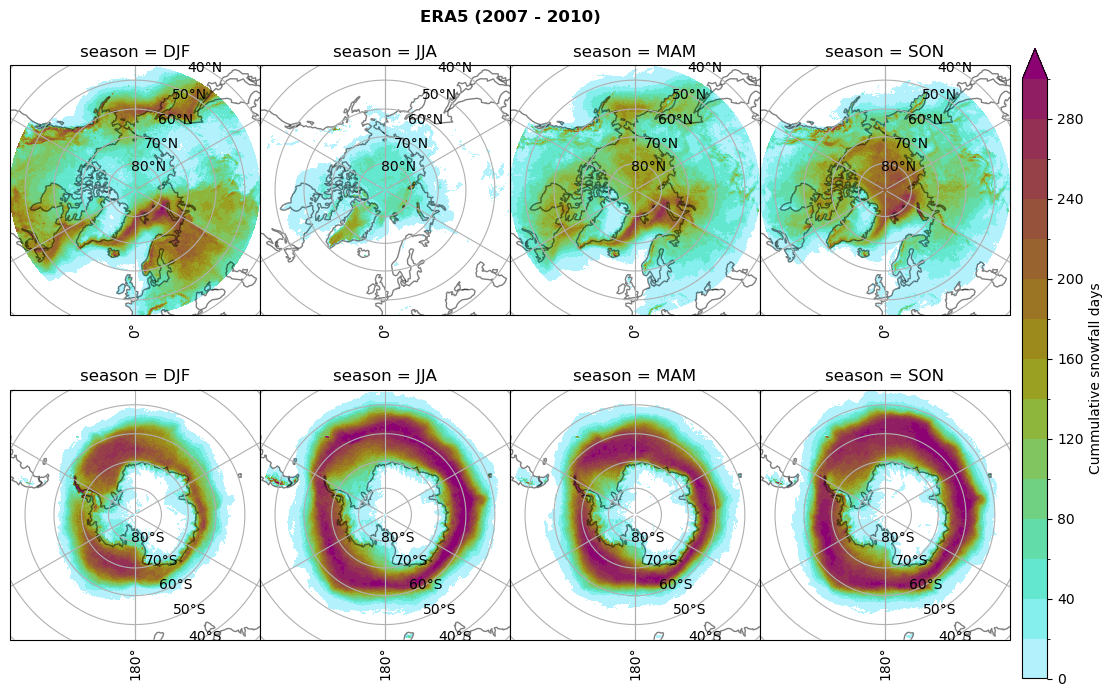

In [17]:
# Cummulative snowfall days
figname = 'cum_sf_days_season_mean_{}_{}.png'.format(starty, endy)
plt_seasonal_NH_SH(ds_era['lcc_count'].where(ds_era['lcc_count']>0.), levels=np.arange(0,320,20), cbar_label='Cummulative snowfall days', plt_title='ERA5 ({} - {})'.format(starty,endy))
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)


In [18]:



# # seasonal precip efficeny ICE+LIQUID
# figname = 'ice_liquid_precip_eff_season_mean_{}_{}.png'.format(starty, endy)
# sf_twp = ((ds_era['sf_lcc']/((ds_era['lwp_lcc']+ds_era['iwp_lcc']))).groupby('time.season').mean('time', keep_attrs=True, skipna=True))
# plt_seasonal_NH_SH(sf_twp, np.arange(0, 1.05,0.05),cbar_label='Mean seasonal precip. efficency', plt_title='ERA Snowfall/(IWP + LWP) ({} - {})'.format(starty,endy))
# plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

# # seasonal liquid water path
# figname = 'lwp_season_mean_{}_{}.png'.format(starty, endy)
# lwp_season = ds_era['lwp_lcc'].groupby('time.season').mean(dim='time',keep_attrs=True, skipna=True)
# plt_seasonal_NH_SH(lwp_season, np.arange(0, 0.310, 0.010),cbar_label='{} ({})'.format(lwp_season.attrs['long_name'], lwp_season.attrs['units']),plt_title='ERA5 {} ({} - {})'.format(lwp_season.attrs['long_name'], starty,endy))
# plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

# # seasonal snowfall
# figname = 'sf_season_mean_{}_{}.png'.format(starty, endy)
# sf_season = ds_era['sf_lcc'].groupby('time.season').mean(dim='time',keep_attrs=True, skipna=True)
# plt_seasonal_NH_SH(sf_season, np.arange(0, 0.325, 0.025),cbar_label='{} ({})'.format(sf_season.attrs['long_name'], sf_season.attrs['units']),plt_title='ERA5 {} ({} - {})'.format(sf_season.attrs['long_name'], starty,endy))
# plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

# # mixed phase path fraction (ICE)
# figname = 'iwp_twp_season_mean_{}_{}.png'.format(starty, endy)
# iwp_twp = ((ds_era['iwp_lcc']/(ds_era['lwp_lcc']+ds_era['iwp_lcc'])).groupby('time.season').mean('time', keep_attrs=True, skipna=True))
# plt_seasonal_NH_SH(iwp_twp, np.arange(0, 1.05, .05),cbar_label='Mixed phase path fraction', plt_title='ERA IWP/(IWP + LWP) ({} - {})'.format(starty,endy))
# plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

# # mixed phase path fraction (LIQUID)
# figname = 'lwp_twp_season_mean_{}_{}.png'.format(starty, endy)
# lwp_twp = ((ds_era['lwp_lcc']/(ds_era['lwp_lcc']+ds_era['iwp_lcc'])).groupby('time.season').mean('time', keep_attrs=True, skipna=True))
# plt_seasonal_NH_SH(lwp_twp, np.arange(0, 1.05, .05),cbar_label='Mixed phase path fraction', plt_title='ERA LWP/(IWP + LWP) ({} - {})'.format(starty,endy))
# plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)


# figname = 'sf_iwp_twp_season_mean_{}_{}.png'.format(starty, endy)
# sf_iwp_twp = (ds_era['sf_lcc']*(ds_era['iwp_lcc']/(ds_era['lwp_lcc']+ds_era['iwp_lcc']))).groupby('time.season').mean('time', keep_attrs=True, skipna=True)
# plt_seasonal_NH_SH(sf_iwp_twp, np.arange(0,0.175, 0.025),cbar_label='Mean seasonal snowfall * Mixed phase path fraction (mm)', plt_title='ERA snowfall * IWP/TWP ({} - {})'.format(starty,endy))
# plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

# figname = 'sf_lwp_twp_season_mean_{}_{}.png'.format(starty, endy)
# sf_lwp_twp = (ds_era['sf_lcc']*(ds_era['lwp_lcc']/(ds_era['lwp_lcc']+ds_era['iwp_lcc']))).groupby('time.season').mean('time', keep_attrs=True, skipna=True)
# plt_seasonal_NH_SH(sf_lwp_twp, np.arange(0,0.175, 0.025),cbar_label='Mean seasonal snowfall * Mixed phase path fraction (mm)', plt_title='ERA snowfall * LWP/TWP ({} - {})'.format(starty,endy))
# plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

# # Mean seasonal snowfall phase ratio
# figname = 'mixed_phase_sf_phase_ratio_season_mean_{}_{}.png'.format(starty, endy)
# plt_seasonal_NH_SH((sf_iwp_twp/sf_lwp_twp), np.arange(0, 5.5, 0.5),cbar_label='Snowfall phase ratio', plt_title='ERA Mean seasonal snowfall phase ratio ({} - {})'.format(starty,endy))
# plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)


## Calculating bin and bin sizes
https://www.statisticshowto.com/choose-bin-sizes-statistics/

Useful to plot TWP vs. Snowfall (precipitation efficency)

In [19]:
def plt_seasonal_2dhist_wp_sf(x_value, y_value, plt_title, xlabel, ylabel):
    f, axsm = plt.subplots(nrows=2,ncols=4,figsize =[10,5], sharex=True, sharey=True)
    # cmap = cm.batlow
    cmap = cm.hawaii_r
    # levels = np.arange(0.1,65000,5000)
    # norm = BoundaryNorm(levels, ncolors=cmap.N, )
    norm = LogNorm(vmin=1, vmax=50000)



    for ax, season in zip(axsm.flatten()[:4], x_value.season):
        ax.plot([0, 1], [0, 1],ls="--", c=".6", transform=ax.transAxes)
        Z, xedges, yedges = np.histogram2d((x_value.where(x_value['lat'] >=45).sel(season=season).values.flatten()), 
                                        (y_value.where(y_value['lat'] >=45).sel(season=season).values.flatten()), 
                                        bins=[40, 40], 
                                        range=[[0,4],[0, 4]])   

        im = ax.pcolormesh(xedges, yedges, Z.transpose(),cmap=cmap,norm=norm,)
        # cbar = f.colorbar(im, ax=ax,)
        ax.set(title =r'lat$\geq 45^\circ$N; season = {}'.format(season.values))
        ax.grid()
        
        _corr = xr.corr(x_value.where(x_value['lat'] >=45).sel(season=season), y_value.where(y_value['lat'] >=45).sel(season=season))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.55, 0.95, 'Corr: {}'.format(np.round(_corr,3).values), transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)
        
        

    for ax, season in zip(axsm.flatten()[4:], x_value.season):
        ax.plot([0, 1], [0, 1],ls="--", c=".6", transform=ax.transAxes)
        Z, xedges, yedges = np.histogram2d((x_value.where(x_value['lat'] <=-45).sel(season=season).values.flatten()), 
                                        (y_value.where(y_value['lat'] <=-45).sel(season=season).values.flatten()), 
                                        bins=[40, 40], 
                                        range=[[0,4],[0, 4]])   

        im = ax.pcolormesh(xedges, yedges, Z.transpose(), cmap=cmap,norm=norm,)
        # cbar = f.colorbar(im, ax=ax, )
        ax.set(title =r'lat$\leq-45^\circ$S; season = {}'.format(season.values))
        
        ax.set_xlabel('{} ({})'.format(xlabel,x_value.attrs['units']))
        ax.grid()
        
        _corr = xr.corr(x_value.where(x_value['lat'] <=-45).sel(season=season), y_value.where(y_value['lat'] <=-45).sel(season=season))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.55, 0.95, 'Corr: {}'.format(np.round(_corr,3).values), transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)
        
    axsm.flatten()[0].set_ylabel('{} ({})'.format(ylabel, y_value.attrs['units']))
    axsm.flatten()[4].set_ylabel('{} ({})'.format(ylabel, y_value.attrs['units']))


    cbaxes = f.add_axes([1.0125, 0.025, 0.025, 0.9])
    cbar = plt.colorbar(im, cax=cbaxes, shrink=0.5, orientation='vertical', label='Frequency')
    f.suptitle(plt_title, fontweight="bold");
    
    
    
    
    plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)


In [20]:
lwp = ds_era['lwp_lcc'].groupby('time.season').mean(('time', ), keep_attrs=True, skipna=True)
iwp = ds_era['iwp_lcc'].groupby('time.season').mean(('time', ), keep_attrs=True, skipna=True)
sf = ds_era['sf_lcc'].groupby('time.season').mean(('time', ), keep_attrs=True, skipna=True)

# Total water path
twp = ds_era['twp_lcc'].groupby('time.season').mean(('time', ), keep_attrs=True, skipna=True)

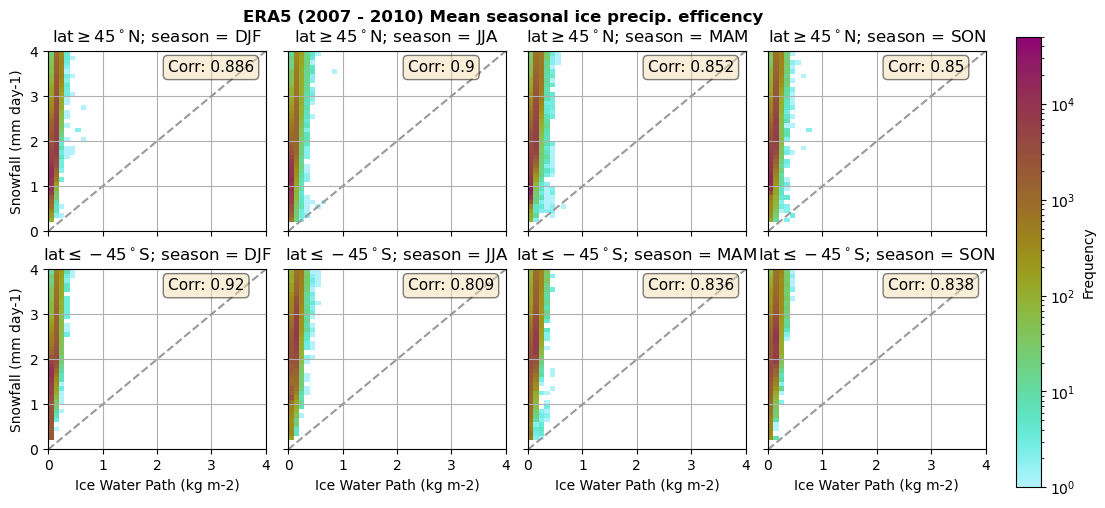

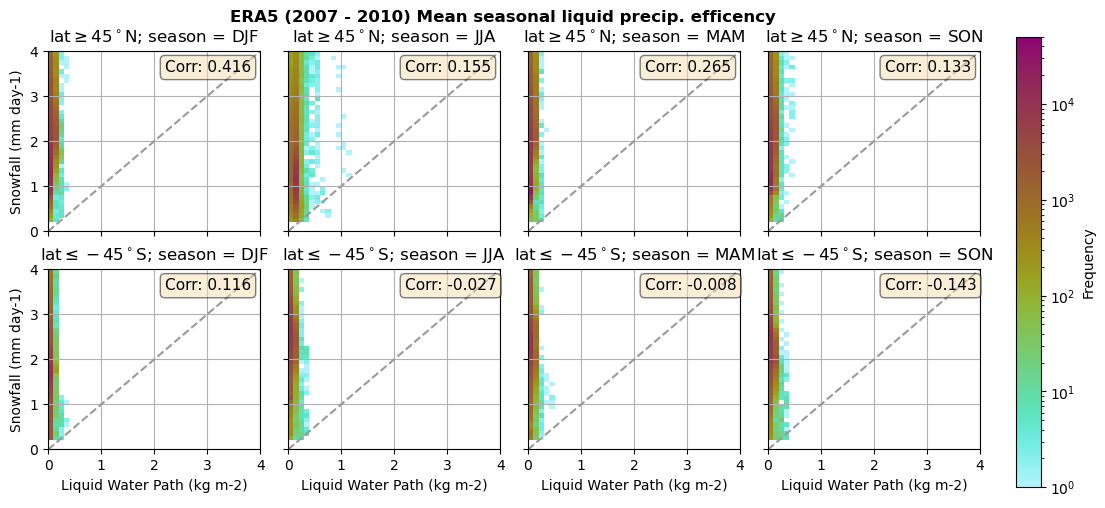

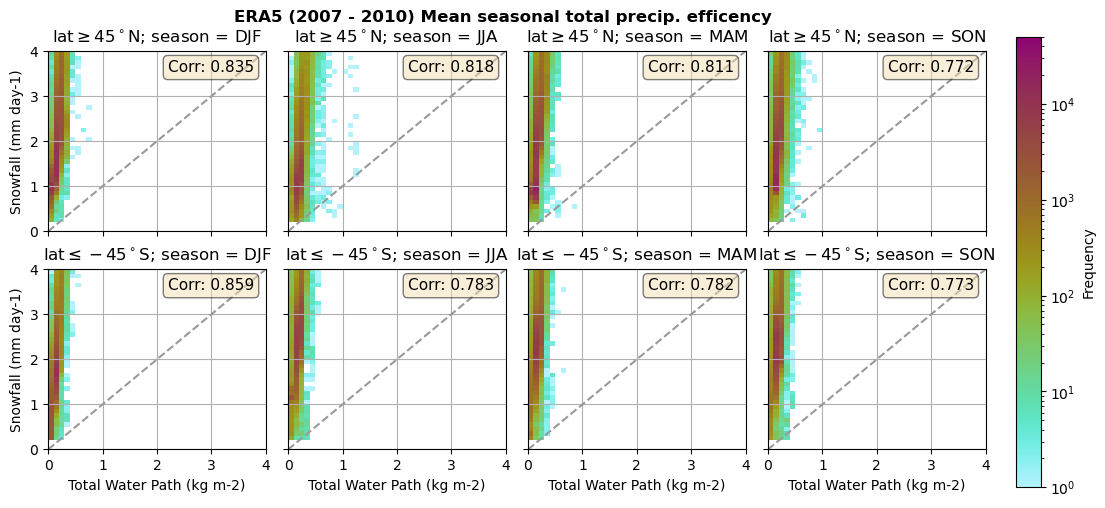

In [21]:
# precip efficency from ice
figname = '2dhist_iwp_sf_season_mean_{}_{}.png'.format(starty, endy)
plt_seasonal_2dhist_wp_sf(iwp, sf, 'ERA5 ({} - {}) Mean seasonal ice precip. efficency'.format(starty,endy), 'Ice Water Path', 'Snowfall')
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

# precip efficency from liquid
figname = '2dhist_lwp_sf_season_mean_{}_{}.png'.format(starty, endy)
plt_seasonal_2dhist_wp_sf(lwp, sf, 'ERA5 ({} - {}) Mean seasonal liquid precip. efficency'.format(starty,endy), 'Liquid Water Path', 'Snowfall')
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

# precip efficency from mixed-phase clouds
figname = '2dhist_lwp_iwp_sf_season_mean_{}_{}.png'.format(starty, endy)
plt_seasonal_2dhist_wp_sf(twp, sf, 'ERA5 ({} - {}) Mean seasonal total precip. efficency'.format(starty,endy), 'Total Water Path', 'Snowfall')
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)


## Precipitation efficency - spatial

In [22]:
# calculate precipitation efficency
ds_era['precip_eff'] = ds_era['sf_lcc']/ds_era['twp_lcc']

In [28]:
# calculate days in each season for each year
sum_DJF = dict()
sum_MAM = dict()
sum_JJA = dict()
sum_SON = dict()
for year in np.unique(ds_era.time.dt.year):
    year=str(year)
    sum_DJF[year] = len(ds_era['precip_eff'].sel(time=year+'-01')) + len(ds_era['precip_eff'].sel(time=year+'-02')) + len(ds_era['precip_eff'].sel(time=year+'-12'))
    sum_MAM[year] = len(ds_era['precip_eff'].sel(time=year+'-03')) + len(ds_era['precip_eff'].sel(time=year+'-04')) + len(ds_era['precip_eff'].sel(time=year+'-05'))
    sum_JJA[year] = len(ds_era['precip_eff'].sel(time=year+'-06')) + len(ds_era['precip_eff'].sel(time=year+'-07')) + len(ds_era['precip_eff'].sel(time=year+'-08'))
    sum_SON[year] = len(ds_era['precip_eff'].sel(time=year+'-09')) + len(ds_era['precip_eff'].sel(time=year+'-10')) + len(ds_era['precip_eff'].sel(time=year+'-11'))
    
days_DJF = sum(sum_DJF.values())
days_MAM = sum(sum_MAM.values())
days_JJA = sum(sum_JJA.values())
days_SON = sum(sum_SON.values())

In [29]:
# calculate sum of monthly precip eff
precip_eff_mon = ds_era['precip_eff'].groupby('time.month').sum('time',skipna=True)

# calculate sum of each season precipitation eff
precip_eff = dict()
precip_eff['DJF'] = (precip_eff_mon.sel(month=1) + precip_eff_mon.sel(month=2) + precip_eff_mon.sel(month=12))/days_DJF
precip_eff['MAM'] = (precip_eff_mon.sel(month=3) + precip_eff_mon.sel(month=4) + precip_eff_mon.sel(month=5))/days_MAM
precip_eff['JJA'] = (precip_eff_mon.sel(month=6) + precip_eff_mon.sel(month=7) + precip_eff_mon.sel(month=8))/days_JJA
precip_eff['SON'] = (precip_eff_mon.sel(month=9) + precip_eff_mon.sel(month=10) + precip_eff_mon.sel(month=11))/days_SON

_da = list(precip_eff.values())
_coord = list(precip_eff.keys())
    
ds_era['precip_eff_seas'] = xr.concat(objs=_da, dim=_coord, coords='all').rename({'concat_dim':'season'})

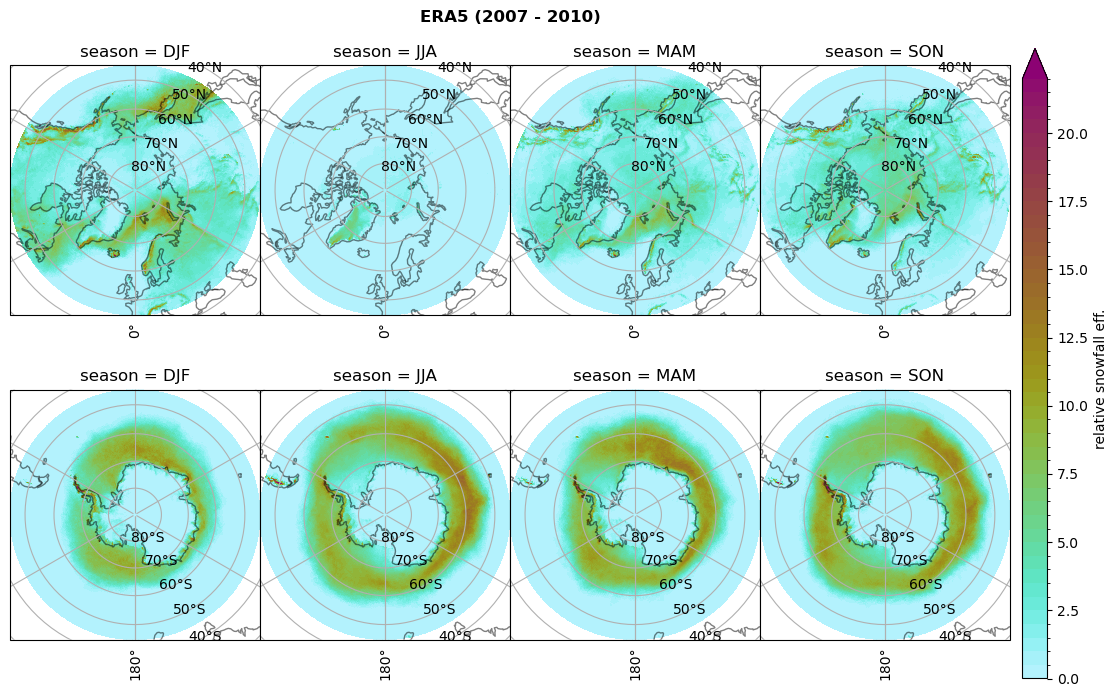

In [31]:
# Plot precipitation efficency
plt_seasonal_NH_SH(ds_era['precip_eff_seas'], np.arange(0., 22.5,.5), 'relative snowfall eff.', 'ERA5 ({} - {})'.format(starty,endy))

# save precip efficency from mixed-phase clouds figure
figname = '{}_sf_twp_season_mean_{}_{}.png'.format('ERA5', starty, endy)
plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)

## Relative frequency

$$RF = \frac{f}{n} = \frac{\text{number of times the data occurred in an observation}}{\text{total frequency}}$$

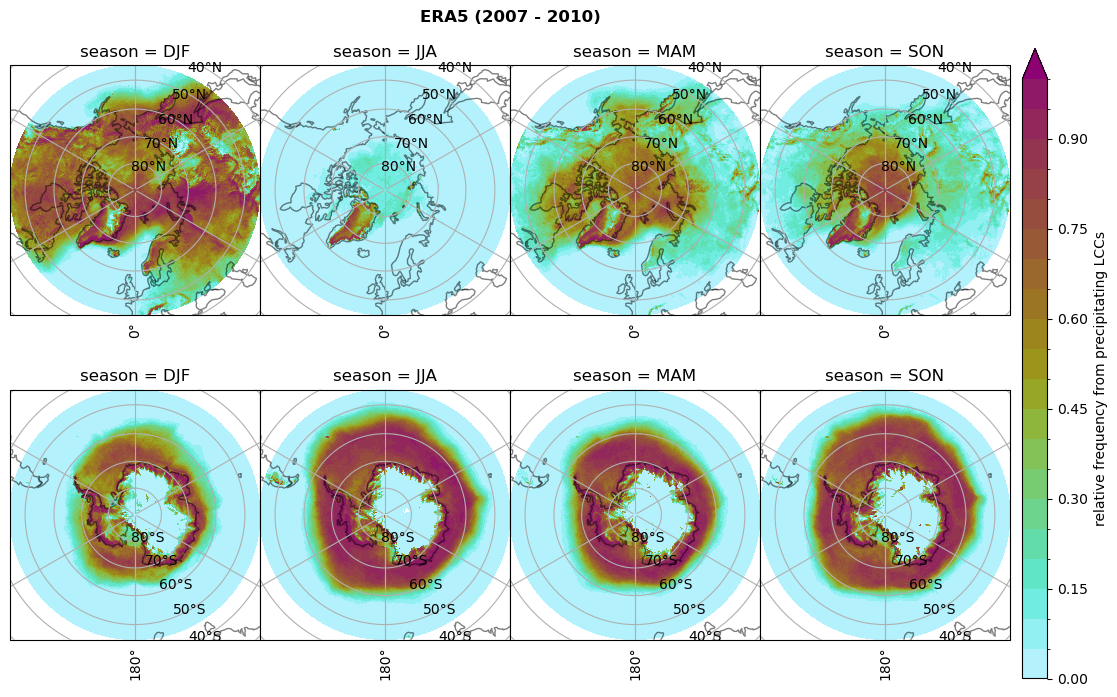

In [32]:
n = ds_era['lwp'].groupby('time.season').sum('time',skipna=True)
f= ds_era['lwp_lcc'].groupby('time.season').sum('time',skipna=True)
ds_era['rf_lcc'] = f/n
plt_seasonal_NH_SH(ds_era['rf_lcc'], np.arange(0,1.05,0.05), 'relative frequency from precipitating LCCs', 'ERA5 ({} - {})'.format(starty,endy))

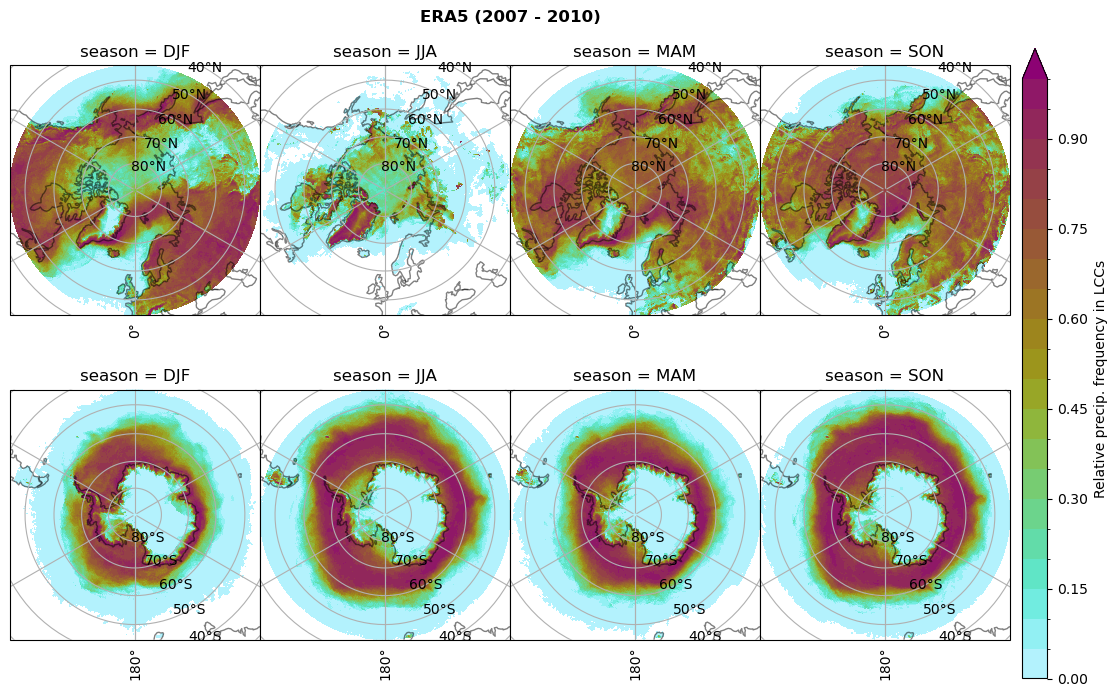

In [33]:
n = ds_era['sf'].groupby('time.season').sum('time',skipna=True)
f= ds_era['sf_lcc'].groupby('time.season').sum('time',skipna=True)
ds_era['rf_sf_lcc'] = f/n
plt_seasonal_NH_SH(ds_era['rf_sf_lcc'], np.arange(0,1.05,0.05), 'Relative precip. frequency in LCCs', 'ERA5 ({} - {})'.format(starty,endy))

## Regrid ERA5 data to common CMIP6 model grid <a id='regrid_hz'></a>

We want to conduct statistical analysis at the annual and seasonal timescales to determine the biases in cloud phase and precipitation (liquid and solid) for the CMIP6 models in comparison to ERA5. 

The ERA5 data has a nominal resolution of 0.25 deg and has to be regridded to the same horizontal resolution as the CMIP6 model. Hence we will make use of the python package `xesmf` and [decreasing resolution](https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html#Decreasing-resolution), [Limitations and warnings](https://xesmf.readthedocs.io/en/latest/notebooks/Masking.html?highlight=conservative#Limitations-and-warnings).  

$\rightarrow$ Define CMIP6 model as the reference grid `ds_out`.

Save all variables in one file and each variable to a `netcdf` datasets between 2007 an 2010, locally.

> **_NOTE:_** This can take a while, so be patient



In [34]:
list_models = ['MIROC6', 
               'CESM2', 
               'CanESM5', 
               'AWI-ESM-1-1-LR', 
               'MPI-ESM1-2-LR', 
            #    'UKESM1-0-LL', 
            #    'HadGEM3-GC31-LL',
               'CNRM-CM6-1',
               'CNRM-ESM2-1',
               'IPSL-CM6A-LR',
               'IPSL-CM5A2-INCA']

In [35]:
counter = 0
era_in_grid = {}

for model in list_models:
    # Read in the output grid from CMIP6 model
    ds_model = xr.open_dataset(glob('{}/cmip6_hist/daily_means/prsn_day_{}_historical_*.nc'.format(INPUT_DATA_DIR,model))[0], drop_variables=('prsn','time_bnds', 'lat_bnds','lon_bnds'), use_cftime=True)

    # select only latitude and longitude needed for analysis
    ds_model=ds_model.drop('time')
    # shift longitude to be from -180 to 180
    ds_model = ds_model.assign_coords(lon=(((ds_model['lon'] + 180) % 360) - 180)).sortby('lon')
    
    # Regrid data
    SH = fct.regrid_data(ds_era.sel(lat=slice(-90,-45)), ds_model.sel(lat=slice(-90,-45)))
    NH = fct.regrid_data(ds_era.sel(lat=slice(45,90)), ds_model.sel(lat=slice(45,90)))
    
    era_in_grid[model] = xr.concat([SH, NH], 'lat')

    filename = 'ERA5_daily_mean_{}_{}01_{}12.nc'.format(model,starty, endy)
    era_file_out = os.path.join(era_out, 'model_grid/' +filename)
    
    try:
        os.mkdir(os.path.join(era_out, 'model_grid'))
    except OSError:
        pass

    files = glob(era_file_out)
    if era_file_out in files:
    #     print('{} is downloaded'.format(era_file_out))
    #     counter += 1
    #     print('Have regridded in total: {:} files'.format(str(counter))) 
    # else: # Save to netcdf file
        era_in_grid[model].to_netcdf(era_file_out)
        print('file written: {}'.format(era_file_out))


sf True
2t True
tciw True
tclw True
tcrw True
tcslw True
tcsw True
tcw True
iwp True
lwp True
twp True
lcc_count True
sf_lcc True
iwp_lcc True
lwp_lcc True
twp_lcc True
precip_eff True
precip_eff_seas True
rf_lcc True
rf_sf_lcc True
sf True
2t True
tciw True
tclw True
tcrw True
tcslw True
tcsw True
tcw True
iwp True
lwp True
twp True
lcc_count True
sf_lcc True
iwp_lcc True
lwp_lcc True
twp_lcc True
precip_eff True
precip_eff_seas True
rf_lcc True
rf_sf_lcc True
file written: /scratch/franzihe/output/ERA5/daily_means/model_grid/ERA5_daily_mean_MIROC6_200701_201012.nc
sf True
2t True
tciw True
tclw True
tcrw True
tcslw True
tcsw True
tcw True
iwp True
lwp True
twp True
lcc_count True
sf_lcc True
iwp_lcc True
lwp_lcc True
twp_lcc True
precip_eff True
precip_eff_seas True
rf_lcc True
rf_sf_lcc True
sf True
2t True
tciw True
tclw True
tcrw True
tcslw True
tcsw True
tcw True
iwp True
lwp True
twp True
lcc_count True
sf_lcc True
iwp_lcc True
lwp_lcc True
twp_lcc True
precip_eff True
precip_ef

## Mask atmopsheric temperature

During the process of finding the SLF50, SLF30, SLF70 we encountered the problem, that the atmospheric temperature is too cold with $T<175K$. To avoid cold temperatures we will mask the atmospheric temperature values. For this we will try a few thresholds and see how it looks on a spatial map, if we are masking too many temperatures then we know that our threshold is too warm.

Test for:
- 150K = -123.15 $^oC$ 
- 175K = -98.15 $^oC$ 
- 200K = -73.15 $^oC$ 
- 210K = -63.15 $^oC$ 
- 220K = -53.15 $^oC$
- 230K = -43.15 $^oC$ 

We have different possibilities to mask the temperature:
1. Mask t, but all the other vertical variables still keep their values where t<threshold
2. Mask t, and all other vertical variables where t<threshold
3. Mask t, find the lowest pressure level and t, if t==NaN then take the atmospheric pressure, temperature from the layer above

> use Method 1. for now

In [30]:
# var_id = 't'
# temp = (150, 175, 200, 210, 220, 230)
# for t in temp:
#     ds_era['{}_{}'.format(var_id, t)] = ds_era[var_id].where(ds_era[var_id] >= t)

In [31]:
# counter = 0

# keys = 'ERA5'

# # Regrid data
# era_in_1deg = fct.regrid_data(ds_era, ds_out)


# filename = '{}_Amon_1deg_{}01_{}12.nc'.format(keys,starty, endy)
# era_file_out = os.path.join(era_out, filename)
# files = glob(era_file_out)
# if era_file_out in files:
# #     print('{} is downloaded'.format(era_file_out))
# #     counter += 1
# #     print('Have regridded in total: {:} files'.format(str(counter))) 
# # else: # Save to netcdf file
#     era_in_1deg.to_netcdf(era_file_out)
#     print('file written: {}'.format(era_file_out))


In [32]:
# for var_id in era_in_1deg.data_vars:
#     if var_id.find('occurence')==-1:
#         # select where data should be saved
#         filename = '{}_{}_Amon_1deg_{}01_{}12.nc'.format(var_id, keys,starty, endy)
#         era_file_out = os.path.join(era_out, filename)
#         files = glob(era_file_out)
#         if era_file_out in files:
#         #     print('{} is downloaded'.format(era_file_out))
#         #     counter += 1
#         #     print('Have regridded in total: {:} files'.format(str(counter))) 
#         # else: # Save to netcdf file
#             era_in_1deg[var_id].to_netcdf(era_file_out)
#             print('file written: {}'.format(era_file_out))

In [33]:
# ERA5 data
# rsync -av --progress /scratch/franzihe/output/ERA5/monthly_means/1deg/ login.nird.sigma2.no:/projects/NS9600K/data/ERA5/monthly_means/1deg/

# 3. Exploratory Data Analysis <a id='exploratory'></a>

## Create global mean and seasonal mean/spread of all ERA5 data

In [34]:
# # 0.25 deg resolution data
# season_mean_025deg = ds_era.copy()
# for var_id in ds_era.data_vars:
#     if var_id.find('occurence')==-1:
#         season_mean_025deg = fct.seasonal_mean_std(season_mean_025deg, var_id)
# season_mean_025deg = season_mean_025deg.drop_dims('time')

# # 1 deg resolution data
# season_mean_1deg = era_in_1deg.copy()
# for var_id in era_in_1deg.data_vars:
#     if var_id.find('occurence')==-1:
#         season_mean_1deg = fct.seasonal_mean_std(season_mean_1deg, var_id)
# season_mean_1deg = season_mean_1deg.drop_dims('time')

## Find mixed-phase clouds
Calculate the IWC/LWC statistics given by the values. Setting the value to 0.5 will find the level in the atmosphere where IWC and LWC are 50/50. Setting it to a value of 0.7 will find the level where IWC is 70% while LWC is 30%.

1. find the fraction of IWC to LWC 
$$SLF = \frac{LWC}{IWC + LWC}$$ 
$$SLF: \text{Super-cooled liquid water fraction}$$

2. find the nearest value to given IWC-fraction
3. find atmospheric pressure levels where IWC/LWC fraction occurs
4. find the index of the first atmospheric pressure level
5. use the index to select variables


Create dictionary from the list of datasets we want to use for the IWC/LWC statistics


In [35]:
# SLF = {'SLF50':0.5, 'SLF70':0.7, 'SLF30':0.5}


# # find IWC/LWC levels
# ds_era_025deg = fct.dataset_IWC_LWC_level(ds_era, SLF, 'clwc', 'cisc', keys)

# ds_era_1deg = fct.dataset_IWC_LWC_level(era_in_1deg, SLF, 'clwc', 'cisc', keys)

# season_mean_025deg = fct.dataset_IWC_LWC_level(season_mean_025deg, SLF, 'clwc_mean', 'cisc_mean', keys)

# season_mean_1deg = fct.dataset_IWC_LWC_level(season_mean_1deg, SLF, 'clwc_mean', 'cisc_mean', keys)



## Plot the seasonal mean of each variable 

- for the original dataset
- and where the IWC/LWC level were found
    - for IWC/LWC 50/50
    - for IWC/LWC 70/30
    - for IWC/LWC 30/70   

All plots are for ERA resolution at 1 deg.


In [36]:
# stat = 'ERA5_SLF50'
# var_id = 't'
# extend = 'both'
# title = '{} {} ({} - {})'.format(stat, var_id, starty, endy)

# variable = season_mean_025deg[var_id+'_mean'].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True)
            
# global_mean = ds_era_025deg[var_id].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True).mean(('latitude', 'longitude'),skipna=True, keep_attrs=True).groupby("time.season").mean("time", skipna=True, keep_attrs=True)


# fg = variable.plot(
#         col="season",
#         col_wrap=2,
#         transform=ccrs.PlateCarree(),  # remember to provide this!
#         subplot_kws={
#             "projection": ccrs.PlateCarree()
#         },
#         cbar_kwargs={"orientation": "vertical", "shrink": 0.8, "aspect": 40},
#         cmap=cm.devon_r, 
#         figsize=[10, 7],
#         robust=True,
#         extend=extend,
#         # add_colorbar=False,
#         # vmin=fct.plt_dict[var_id][fct.plt_dict['header'].index('vmin')],
#         # vmax=fct.plt_dict[var_id][fct.plt_dict['header'].index('vmax')],
#         # levels=fct.plt_dict[var_id][fct.plt_dict['header'].index('levels')],
#     )
# for ax, i in zip(fg.axes.flat, variable.season.values):
#         ax.set_title('season: {}, global mean: {:.3f}'.format(i, global_mean.sel(season=i).values))
    

# fg.map(lambda: plt.gca().coastlines())
# fg.fig.suptitle(title, fontsize=16, fontweight="bold")
# # fg.add_colorbar(fraction=0.05, pad=0.04)

# # fg.cbar.set_label(label='{}'.format(fct.plt_dict[var_id][fct.plt_dict['header'].index('label')], weight='bold'))
    

In [37]:
# for t in temp:
#     var_id = 't_{}'.format(t)
#     title = '{} {} ({} - {})'.format(stat, var_id, starty, endy)

#     variable = season_mean_025deg[var_id+'_mean'].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True)
                
#     global_mean = ds_era_025deg[var_id].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True).mean(('latitude', 'longitude'),skipna=True, keep_attrs=True).groupby("time.season").mean("time", skipna=True, keep_attrs=True)


#     fg = variable.plot(
#             col="season",
#             col_wrap=2,
#             transform=ccrs.PlateCarree(),  # remember to provide this!
#             subplot_kws={
#                 "projection": ccrs.PlateCarree()
#             },
#             cbar_kwargs={"orientation": "vertical", "shrink": 0.8, "aspect": 40},
#             cmap=cm.devon_r, 
#             figsize=[10, 7],
#             robust=True,
#             extend=extend,
#             # add_colorbar=False,
#             # vmin=fct.plt_dict['t'][fct.plt_dict['header'].index('vmin')],
#             # vmax=fct.plt_dict['t'][fct.plt_dict['header'].index('vmax')],
#             # levels=fct.plt_dict['t'][fct.plt_dict['header'].index('levels')],
#         )

#     for ax, i in zip(fg.axes.flat, variable.season.values):
#         ax.set_title('season: {}, global mean: {:.3f}'.format(i, global_mean.sel(season=i).values))
    

#     fg.map(lambda: plt.gca().coastlines())
#     fg.fig.suptitle(title, fontsize=16, fontweight="bold")
#     # fg.add_colorbar(fraction=0.05, pad=0.04)

#     # fg.cbar.set_label(label='{}'.format(fct.plt_dict['t'][fct.plt_dict['header'].index('label')], weight='bold'))
        

In [38]:
# var_id = 't'
# for t in temp:
#     title = '{} {}_{}-{} ({} - {})'.format(stat, var_id, t, var_id, starty, endy)
#     _diff = season_mean_025deg['{}_{}_mean'.format(var_id,t)].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True) - season_mean_025deg[var_id+'_mean'].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True)
    
#     fg = _diff.plot(col="season",
#                 col_wrap=2,
#                 transform=ccrs.PlateCarree(),  # remember to provide this!
#                 subplot_kws={
#                     "projection": ccrs.PlateCarree()
#                 },
#                 cbar_kwargs={"orientation": "vertical", "shrink": 0.8, "aspect": 40},
#                 cmap=cm.bam, 
#                 figsize=[10, 7],
#                 robust=True,
#                 extend=extend,
#                 vmin=-0.4,
#                 vmax=0.4,
#                 levels=20,
#                 )

#     fg.map(lambda: plt.gca().coastlines())
#     fg.fig.suptitle(title, fontsize=16, fontweight="bold")

In [39]:
# for stat in season_mean_1deg.statistic.values:
#     for var_id in ds_era.data_vars:
#         if var_id == '2t' or var_id=='t' or var_id=='pressure':
#             extend='both'
#         else:
#             extend='max'
#         if stat == 'ERA5' and var_id.find('occurence')==-1 and (len(ds_era[var_id].dims))==3:
#             # print(stat, var_id)
            
#             variable = season_mean_1deg[var_id+'_mean'].sel(statistic=stat, level=1000)#.sum('level', skipna=True, keep_attrs=True)
            
#             global_mean = ds_era_1deg[var_id].sel(statistic=stat, level=1000).mean(('lat', 'lon'),skipna=True, keep_attrs=True).groupby("time.season").mean("time", skipna=True, keep_attrs=True)
            


#             title = '{} MEAN ({} - {})'.format(stat, starty, endy)
#             fct.plt_spatial_seasonal_mean(variable, global_mean, title, var_id,extend)
            
#             # save seasonal mean + std figure to png
#             figname = '{}_{}_season_mean_1deg_{}_{}.png'.format(var_id,stat, starty, endy)
#             plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)


#         elif stat!= 'ERA5' and var_id.find('occurence')==-1:
#             # print(stat, var_id)
#             variable = season_mean_1deg[var_id+'_mean'].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True)
            
#             global_mean = ds_era_1deg[var_id].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True).mean(('lat', 'lon'),skipna=True, keep_attrs=True).groupby("time.season").mean("time", skipna=True, keep_attrs=True)
            


#             title = '{} MEAN ({} - {})'.format(stat, starty, endy)
#             fct.plt_spatial_seasonal_mean(variable, global_mean, title, var_id, extend)

#             # save seasonal mean + std figure to png
#             figname = '{}_{}_season_mean_1deg_{}_{}.png'.format(var_id,stat, starty, endy)
#             plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)



In [40]:
# lat_SH = (-90, -40); lat_NH = (40,90); step = 5
# iteration_SH = range(lat_SH[1], lat_SH[0], -step)
# iteration_NH = range(lat_NH[0], lat_NH[1], step)

In [41]:
# markers = ['o', 'v', 's']

In [42]:
# for _lat in iteration_SH:
#     print(_lat-step, _lat, ds_era_1deg.sel(statistic=stat, lat=slice(_lat-step, _lat)).lat.values)

In [43]:
# ds_dict = {}
# for _lat in iteration_NH:
#     # print(_lat, _lat+step, ds_era_025deg.sel(statistic=stat, latitude=slice(_lat+step, _lat)).latitude.values)
#     ds_dict['{}_{}'.format(_lat, _lat+step)] = ds_era_025deg.sel(latitude = slice(_lat+step, _lat), ).mean(('longitude', 'latitude', 'level'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)

# for _lat in iteration_SH:
#     ds_dict['{}_{}'.format(_lat, _lat-step)] = ds_era_025deg.sel(latitude = slice(_lat, _lat-step), ).mean(('longitude', 'latitude', 'level'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)



In [44]:
# _ds = list(ds_dict.values())
# _coord = list(ds_dict.keys())
# ds_lat = xr.concat(objs=_ds, dim=_coord, coords="all").rename({'concat_dim':'lat'})


In [45]:
# ds_lat.sel(statistic='ERA5_SLF50',season='DJF').plot.scatter(x='pressure', y='t',hue='lat',hue_style='discrete', add_guide=True, cmap=cm.hawaii)

In [46]:
# season ='DJF'
# ds_lat.sel(statistic='ERA5_SLF50').plot.scatter(col="season",col_wrap=2,
#                                                 x='pressure', y='t', 
#                                                 #size=[10, 7],
#                                                 cmap=cm.hawaii,)
# # ,lat='{}_{}'.format(_lat, _lat-step) label='[{} : {})'.format(_lat-step, _lat)

In [47]:
# fig, axsm = plt.subplots(2,2, figsize=[10,7],sharex=True, sharey=True)
# axs = axsm.flatten()
# for ax, season in zip(axs, season_mean_1deg.season.values):

#     for _lat, c in zip(iteration_SH, cm.hawaii(range(0, 256, int(256/len(iteration_SH))))):

#         _season=ds_era_1deg.sum('level', skipna=True, keep_attrs=True).sel(lat = slice(_lat-step, _lat)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)
#         _month=ds_era_1deg.sum('level', skipna=True, keep_attrs=True).sel(lat = slice(_lat-step, _lat)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.month').mean('time', skipna=True, keep_attrs=True)
       
#         _season.sel(statistic=stat, season=season).plot.scatter(ax=ax, x='pressure', y='t', label='[{} : {})'.format(_lat-step, _lat), color=c, marker='p')
#         # if season =='DJF':
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[11:], markers):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                   x='pressure', y='t',
#         #                                                                   label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                   color=c, marker=marker)
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[:2], markers[1:]):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                  x='pressure', y='t',
#         #                                                                  label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                  color=c, marker=marker)
        
#         # if season=='MAM':
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[2:5], markers):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                  x='pressure', y='t',
#         #                                                                  label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                  color=c, marker=marker)
        
#         # if season=='JJA':
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[5:8], markers):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                   x='pressure', y='t',
#         #                                                                   label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                   color=c, marker=marker)

#         # if season=='SON':
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[8:11], markers):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                  x='pressure', y='t',
#         #                                                                  label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                  color=c, marker=marker)


# axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize="small", fancybox=True,)
# plt.grid()

In [48]:
# fig, axsm = plt.subplots(2,2, figsize=[10,7],sharex=True, sharey=True)
# axs = axsm.flatten()
# for ax, season in zip(axs, season_mean_1deg.season.values):

#     for _lat, c in zip(iteration_SH, cm.hawaii(range(0, 256, int(256/len(iteration_SH))))):

#         _season=ds_era_1deg.sum('level').sel(lat = slice(_lat-step, _lat)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)
#         _month=ds_era_1deg.sum('level').sel(lat = slice(_lat-step, _lat)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.month').mean('time', skipna=True, keep_attrs=True)
       
#         _season.sel(statistic=stat, season=season).plot.scatter(ax=ax, x='pressure', y='t_220', label='[{} : {})'.format(_lat-step, _lat), color=c, marker='p')
#         # if season =='DJF':
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[11:], markers):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                   x='pressure', y='t',
#         #                                                                   label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                   color=c, marker=marker)
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[:2], markers[1:]):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                  x='pressure', y='t',
#         #                                                                  label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                  color=c, marker=marker)
        
#         # if season=='MAM':
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[2:5], markers):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                  x='pressure', y='t',
#         #                                                                  label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                  color=c, marker=marker)
        
#         # if season=='JJA':
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[5:8], markers):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                   x='pressure', y='t',
#         #                                                                   label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                   color=c, marker=marker)

#         # if season=='SON':
#         #     for month, marker in zip(_month.sel(statistic=stat).month.values[8:11], markers):
#         #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
#         #                                                                  x='pressure', y='t',
#         #                                                                  label='[{} : {})'.format(_lat-step, _lat),
#         #                                                                  color=c, marker=marker)


# axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize="small", fancybox=True,)
# plt.grid()

In [49]:
# for _lat in iteration_NH:
#     print(_lat, _lat+step, ds_era_1deg.sel(statistic='ERA5_50', lat=slice(_lat, _lat+step)).lat.values)

In [50]:
# fig, axsm = plt.subplots(2,2, figsize=[10,7],sharex=True, sharey=True)
# axs = axsm.flatten()
# for ax, season in zip(axs, season_mean_1deg.season.values):

#     for _lat, c in zip(iteration_NH, cm.hawaii(range(0, 256, int(256/len(iteration_NH))))):

#         _season=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)
#         _month=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.month').mean('time', skipna=True, keep_attrs=True)
       
#         _season.sel(statistic='ERA5_50', season=season).plot.scatter(ax=ax, x='t', y='clic', label='[{} : {})'.format(_lat, _lat+step), color=c, marker='p')
#         if season =='DJF':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[11:], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                           x='t', y='clic',
#                                                                           label='[{} : {})'.format(_lat, _lat+step),
#                                                                           color=c, marker=marker)
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[:2], markers[1:]):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='t', y='clic',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)
        
#         if season=='MAM':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[2:5], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='t', y='clic',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)
        
#         if season=='JJA':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[5:8], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                           x='t', y='clic',
#                                                                           label='[{} : {})'.format(_lat, _lat+step),
#                                                                           color=c, marker=marker)

#         if season=='SON':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[8:11], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='t', y='clic',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)


# axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize="small", fancybox=True,)

In [51]:
# fig, axsm = plt.subplots(2,2, figsize=[10,7],sharex=True, sharey=True)
# axs = axsm.flatten()
# for ax, season in zip(axs, season_mean_1deg.season.values):

#     for _lat, c in zip(iteration_NH, cm.hawaii(range(0, 256, int(256/len(iteration_NH))))):

#         _season=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)
#         _month=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.month').mean('time', skipna=True, keep_attrs=True)
       
#         _season.sel(statistic='ERA5_50', season=season).plot.scatter(ax=ax, x='t', y='sf', label='[{} : {})'.format(_lat, _lat+step), color=c, marker='p')
#         if season =='DJF':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[11:], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                           x='t', y='sf',
#                                                                           label='[{} : {})'.format(_lat, _lat+step),
#                                                                           color=c, marker=marker)
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[:2], markers[1:]):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='t', y='sf',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)
        
#         if season=='MAM':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[2:5], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='t', y='sf',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)
        
#         if season=='JJA':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[5:8], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                           x='t', y='sf',
#                                                                           label='[{} : {})'.format(_lat, _lat+step),
#                                                                           color=c, marker=marker)

#         if season=='SON':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[8:11], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='t', y='sf',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)


# axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize="small", fancybox=True,)

In [52]:
# fig, axsm = plt.subplots(2,2, figsize=[10,7],sharex=True, sharey=True)
# axs = axsm.flatten()
# for ax, season in zip(axs, season_mean_1deg.season.values):

#     for _lat, c in zip(iteration_NH, cm.hawaii(range(0, 256, int(256/len(iteration_NH))))):

#         _season=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)
#         _month=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.month').mean('time', skipna=True, keep_attrs=True)
       
#         _season.sel(statistic='ERA5_50', season=season).plot.scatter(ax=ax, x='pressure', y='sf', label='[{} : {})'.format(_lat, _lat+step), color=c, marker='p')
#         if season =='DJF':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[11:], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                           x='pressure', y='sf',
#                                                                           label='[{} : {})'.format(_lat, _lat+step),
#                                                                           color=c, marker=marker)
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[:2], markers[1:]):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='pressure', y='sf',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)
        
#         if season=='MAM':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[2:5], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='pressure', y='sf',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)
        
#         if season=='JJA':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[5:8], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                           x='pressure', y='sf',
#                                                                           label='[{} : {})'.format(_lat, _lat+step),
#                                                                           color=c, marker=marker)

#         if season=='SON':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[8:11], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='pressure', y='sf',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)


# axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize="small", fancybox=True,)

In [53]:
# fig, axsm = plt.subplots(2,2, figsize=[10,7],sharex=True, sharey=True)
# axs = axsm.flatten()
# for ax, season in zip(axs, season_mean_1deg.season.values):

#     for _lat, c in zip(iteration_NH, cm.hawaii(range(0, 256, int(256/len(iteration_NH))))):

#         _season=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)
#         _month=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.month').mean('time', skipna=True, keep_attrs=True)
       
#         _season.sel(statistic='ERA5_50', season=season).plot.scatter(ax=ax, x='pressure', y='t', label='[{} : {})'.format(_lat, _lat+step), color=c, marker='p')
#         if season =='DJF':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[11:], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                           x='pressure', y='t',
#                                                                           label='[{} : {})'.format(_lat, _lat+step),
#                                                                           color=c, marker=marker)
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[:2], markers[1:]):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='pressure', y='t',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)
        
#         if season=='MAM':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[2:5], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='pressure', y='t',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)
        
#         if season=='JJA':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[5:8], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                           x='pressure', y='t',
#                                                                           label='[{} : {})'.format(_lat, _lat+step),
#                                                                           color=c, marker=marker)

#         if season=='SON':
#             for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[8:11], markers):
#                 _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
#                                                                          x='pressure', y='t',
#                                                                          label='[{} : {})'.format(_lat, _lat+step),
#                                                                          color=c, marker=marker)


# axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize="small", fancybox=True,)

## Calculate latitude band mean of variables
We will only use high latitudes and the extratropics the latitude bands are as follow:

1. Southern Hemispher:
    - [-30, -45)
    - [-45, -60)
    - [-60, -75)
    - [-75, -90)
2. Northern Hemisphere:
    - [30, 45)
    - [45, 60)
    - [60, 75)
    - [75, 90)

In [54]:
# lat_SH = (-90, -30); lat_NH = (30,90); step = 15
# iteration_SH = range(lat_SH[1], lat_SH[0], -step)
# iteration_NH = range(lat_NH[0], lat_NH[1], step)

In [55]:
# for var_id in ds_era.keys():
#     for _lat in iteration_SH:

#         # ERA5 original resolution
#         ds_era_025deg[var_id + '_season_{}_{}'.format(_lat, _lat-step)] = ds_era_025deg[var_id + '_season_mean'].sel(lat = slice(_lat, _lat-step)).mean(('lat',), keep_attrs=True, skipna=True)

#         # ERA5 regridded resolution
#         ds_era_1deg[var_id + '_season_{}_{}'.format(_lat, _lat-step)] = ds_era_1deg[var_id + '_season_mean'].sel(lat = slice(_lat-step, _lat)).mean(('lat',), keep_attrs=True, skipna=True)

#     for _lat in iteration_NH:
#         # ERA5 original resolution
#         ds_era_025deg[var_id + '_season_{}_{}'.format(_lat, _lat+step)] = ds_era_025deg[var_id + '_season_mean'].sel(lat = slice(_lat+step, _lat)).mean(('lat',), keep_attrs=True, skipna=True)

#         # ERA5 regridded resolution
#         ds_era_1deg[var_id + '_season_{}_{}'.format(_lat, _lat+step)] = ds_era_1deg[var_id + '_season_mean'].sel(lat = slice(_lat, _lat+step)).mean(('lat',), keep_attrs=True, skipna=True)

In [56]:
# for stat in ds_era_1deg.statistic.values:
#     # Southern Hemisphere
#     fig, axsm = plt.subplots(2, 2, figsize=[10,7], sharex=True, sharey=True)
#     fig.suptitle('{}'.format(stat), fontsize=16, fontweight="bold")

#     axs = axsm.flatten()
#     for ax, i in zip(axs, ds_era_1deg.season):
#         for _lat, c in zip(iteration_SH, cm.romaO(range(0, 256, int(256 / 4)))):
#             ax.scatter( x=ds_era_1deg['t_season_{}_{}'.format(_lat, _lat-step)].sel(statistic=stat).sum('level', skipna=True).sel(season=i), 
#                         y=ds_era_1deg['sf_season_{}_{}'.format(_lat, _lat-step)].sel(statistic=stat).sel(season=i), 
#                         label="{}, {}".format(_lat, _lat - step), 
#                         color=c, 
#                         alpha=0.5)

#     axs[1].legend(
#             loc="upper left",
#             bbox_to_anchor=(1, 1),
#             fontsize="small",
#             fancybox=True,
#         );

#     # Northern Hemisphere
#     fig, axsm = plt.subplots(2, 2, figsize=[10,7], sharex=True, sharey=True)
#     fig.suptitle('{}'.format(stat), fontsize=16, fontweight="bold")

#     axs = axsm.flatten()
#     for ax, i in zip(axs, ds_era_1deg.season):
#         for _lat, c in zip(iteration_NH, cm.romaO(range(0, 256, int(256 / 4)))):
#             ax.scatter( x=ds_era_1deg['t_season_{}_{}'.format(_lat, _lat+step)].sel(statistic=stat).sum('level', skipna=True).sel(season=i), 
#                         y=ds_era_1deg['sf_season_{}_{}'.format(_lat, _lat+step)].sel(statistic=stat).sel(season=i), 
#                         label="{}, {}".format(_lat, _lat + step), 
#                         color=c, 
#                         alpha=0.5)

#     axs[1].legend(
#             loc="upper left",
#             bbox_to_anchor=(1, 1),
#             fontsize="small",
#             fancybox=True,
#         );


# References <a id='references'></a>


[1] Zelinka, M. D., Myers, T. A., McCoy, D. T., Po-Chedley, S., Caldwell, P. M., Ceppi, P., et al. (2020). Causes of higher climate sensitivity in CMIP6 models. Geophysical Research Letters, 47, e2019GL085782. https://doi-org.ezproxy.uio.no/10.1029/2019GL085782 

[2] Bjordal, J., Storelvmo, T., Alterskjær, K. et al. Equilibrium climate sensitivity above 5 °C plausible due to state-dependent cloud feedback. Nat. Geosci. 13, 718–721 (2020). https://doi-org.ezproxy.uio.no/10.1038/s41561-020-00649-1 




<img src="https://drive.google.com/uc?id=1zb0LHvipx8JOXLLrCxzYToJM7eNK4eaw"  height="100" />
<img src="https://reliance.rohub.org/static/media/Reliance-logo.433dc2e9.png"  height="100" />

<img src="https://www.uio.no/vrtx/decorating/resources/dist/src2/images/footer/uio-logo-en.svg"  height="100" />
<img src="https://erc.europa.eu/sites/default/files/logo_0.png"  height="100" />
